In [5]:
import pandas as pd

# Load the data from the Excel file and a CSV file
df_test = pd.read_csv('test_with_predictions.csv')
df_master = pd.read_csv('../master_model/data_model_master_export.csv')

# Create a new column 'master_pattern' in df_master
df_master['master_pattern'] = df_master['thing'] + " " + df_master['property']

# Create a pattern column in df_test that matches the format of 'master_pattern'
df_test['p_pattern'] = df_test['p_thing'].str.replace(r'\d', '#', regex=True) + " " + df_test['p_property'].str.replace(r'\d', '#', regex=True)
df_test['pattern'] = df_test['thing'].str.replace(r'\d', '#', regex=True) + " " + df_test['property'].str.replace(r'\d', '#', regex=True)

# Set of master patterns from df_master
master_patterns = set(df_master['master_pattern'])

# Check each pattern in df_test if it exists in df_master and assign the "p_MDM" field
df_test['p_MDM'] = df_test['p_pattern'].apply(lambda x: "TRUE" if x in master_patterns else "FALSE")
df_test['MDM'] = df_test['pattern'].apply(lambda x: "TRUE" if x in master_patterns else "FALSE")

# Print the total number of rows where 'p_MDM' is 'FALSE'
false_count = (df_test['p_MDM'] == "FALSE").sum()
print(f"Total number of rows where p_MDM is FALSE: {false_count}")

# Crosstab to show the combinations of p_MDM and MDM
mdm_crosstab = pd.crosstab(df_test['p_MDM'], df_test['MDM'])
print(mdm_crosstab)

# This prints a table like:
# MDM       FALSE  TRUE
# p_MDM
# FALSE     x      y
# TRUE      z      w
# z(duplicated

Total number of rows where p_MDM is FALSE: 24125
MDM    FALSE  TRUE
p_MDM             
FALSE  23953   172
TRUE   26134  8799


/tmp/ipykernel_1541853/3646907661.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('test_with_predictions.csv')


In [6]:
df_test['p_thing_property'] = df_test['p_thing']+ " " + df_test['p_property']

# Calculate duplicates for each p_thing_property within each ships_idx
duplicate_counts = df_test.groupby(['ships_idx', 'p_thing_property']).size().reset_index(name='duplicate')

# Merge this count back into the original df_test DataFrame
df_test = df_test.merge(duplicate_counts, on=['ships_idx', 'p_thing_property'], how='left')

# Optionally, if any p_thing_property does not have duplicates, fill NaNs with 0
df_test['duplicate'] = df_test['duplicate'].fillna(0)

# Output to check the merge and duplicate counts
print(df_test[['ships_idx', 'p_thing_property', 'duplicate']].head())

   ships_idx               p_thing_property  duplicate
0       1025           ME1TurboCharger1 RPM        2.0
1       1025  ME1TurboCharger1 LOInletPress        2.0
2       1029  ME1TurboCharger1 LOInletPress        4.0
3       1034               MainEngine1 Load        2.0
4       1017           ME1Flow FOMassFlowIn        2.0


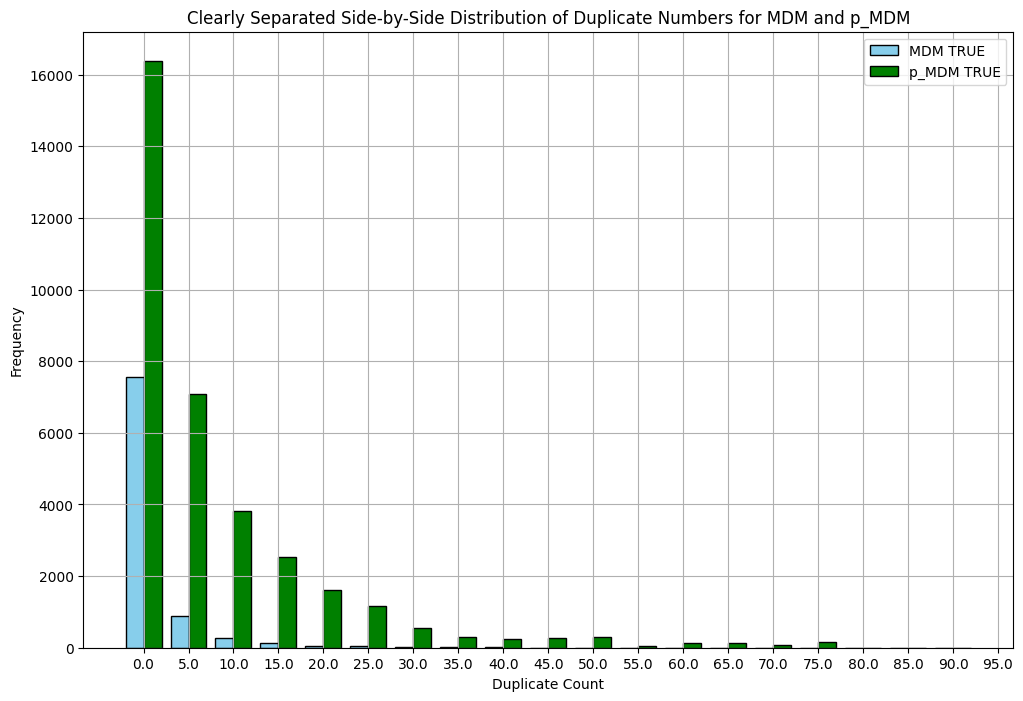

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Filter where MDM is True
mdm_true_df = df_test[df_test['MDM'] == "TRUE"]

# Filter where p_MDM is True
p_mdm_true_df = df_test[df_test['p_MDM'] == "TRUE"]

# Calculate the max duplicate for consistent bin ranges in histograms
max_duplicate = max(mdm_true_df['duplicate'].max(), p_mdm_true_df['duplicate'].max())

# Bins setup
bins = np.arange(0, max_duplicate + 1, 5)  # Ensures both histograms use the same bins

# Histogram data
mdm_hist, _ = np.histogram(mdm_true_df['duplicate'], bins=bins)
p_mdm_hist, _ = np.histogram(p_mdm_true_df['duplicate'], bins=bins)

# Plotting the distribution of 'duplicate' counts
fig, ax = plt.figure(figsize=(12, 8)), plt.gca()

# Width of each bar
bar_width = (bins[1] - bins[0]) * 0.4

# Positions of bars
mdm_positions = bins[:-1] + bar_width / 2
p_mdm_positions = bins[:-1] + 1.5 * bar_width

# Create bars
ax.bar(mdm_positions, mdm_hist, width=bar_width, color='skyblue', edgecolor='black', label='MDM TRUE')
ax.bar(p_mdm_positions, p_mdm_hist, width=bar_width, color='green', edgecolor='black', label='p_MDM TRUE')

plt.title('Clearly Separated Side-by-Side Distribution of Duplicate Numbers for MDM and p_MDM')
plt.xlabel('Duplicate Count')
plt.ylabel('Frequency')
plt.grid(True)

# Setting x-axis ticks in increments of 5 and adjust for bar positions
plt.xticks(bins + bar_width, bins)

# Add legend to distinguish between MDM and p_MDM
plt.legend()

plt.show()


In [8]:
# Save the updated DataFrame back to the Excel file if needed
df_test.to_csv('test_with_predictions_MPM.csv', index=False)  # This creates a new file or overwrites the existing one

print("Update completed.")

Update completed.
